In [1]:
import biograph
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from biograph import graphplot
from biograph import hmrf_estimator
from biograph import probability_field_hmrf_estimator

In [3]:
import graphsonchip
import graphsonchip.analyse

from graphsonchip.graphmaker import make_spheroids
from graphsonchip.graphmaker import graph_generation_func

In [26]:
example_prop_frame = pandas.read_csv('prop_210216_4_individual_tile_1.csv')
#example_prop_frame = pandas.read_csv('210303_18_cut_basic.csv')

loc = example_prop_frame[(example_prop_frame.x < 1500) & 
           (example_prop_frame.y < 1500) & 
           (example_prop_frame.z > 0) & 
           (example_prop_frame.z < 50)]

descriptors = ['label', 'cell_type', 'color']
n_colors = len(loc.cell_type.unique())

In [27]:
loc = loc.drop(columns = 'Unnamed: 0').drop(columns = 'Unnamed: 0.1')
loc.index = np.arange(len(loc))
loc['label'] = loc.index

In [28]:
loc['cell_type'] = loc.cell_type.values.astype(int)

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

loc['color'] = colors

#legend_list = ['CD45+, dividing', 'CD45-, dividing', 'CD45+, not dividing', 'CD45-, not dividing']
#loc['legend'] = [legend_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

spheroid = make_spheroids.single_spheroid_process(loc,
                                       cell_descriptors = descriptors)

G = graph_generation_func.generate_voronoi_graph(spheroid, cell_descriptors = descriptors, dCells = 50)

In [29]:
color_list = [plt.cm.Set3(i) for i in range(n_colors)]
cell_class = nx.get_node_attributes(G, 'cell_type')

for node in G.nodes:
        
    nx.set_node_attributes(G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:cell_class[node]}, 'legend')

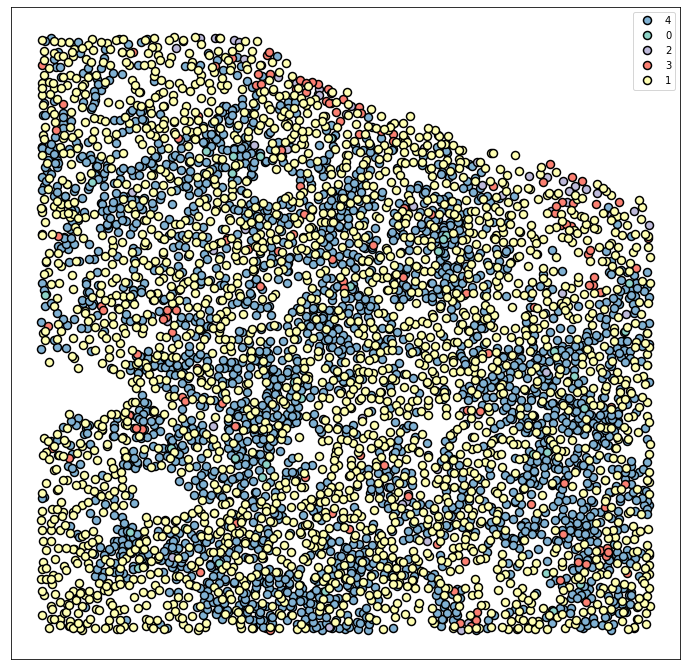

In [30]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (12,12))

In [9]:
biograph = hmrf_estimator.hmrf(G, epochs = 5, gamma = 2)

In [10]:
biograph.initiate_latent_cell_type()

In [11]:
biograph.run()

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


In [12]:
latent_G = biograph.graph

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
cell_class = nx.get_node_attributes(latent_G, 'latent_cell_type')

for node in latent_G.nodes:
        
    nx.set_node_attributes(latent_G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(latent_G, {node:cell_class[node]}, 'legend')

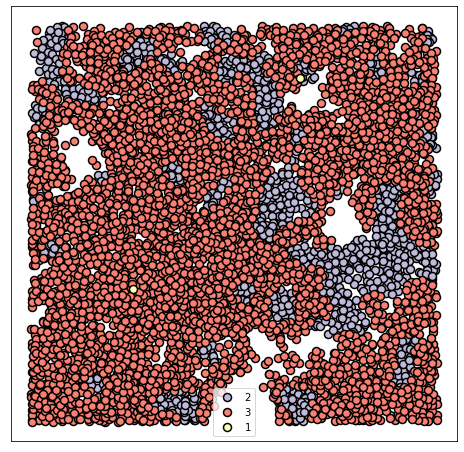

In [13]:
graphplot.scatter_plot_2D(latent_G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [55]:
biograph = probability_field_hmrf_estimator.hmrf(G, epochs = 30, gamma = 0.2, K = 11)

In [56]:
biograph.initiate_latent_probability_field()

100%|██████████| 5015/5015 [00:00<00:00, 37148.81it/s]


In [57]:
biograph.run()

100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


In [64]:
biograph.assign_cell_class(K = 6)

In [65]:
latent_G = biograph.graph

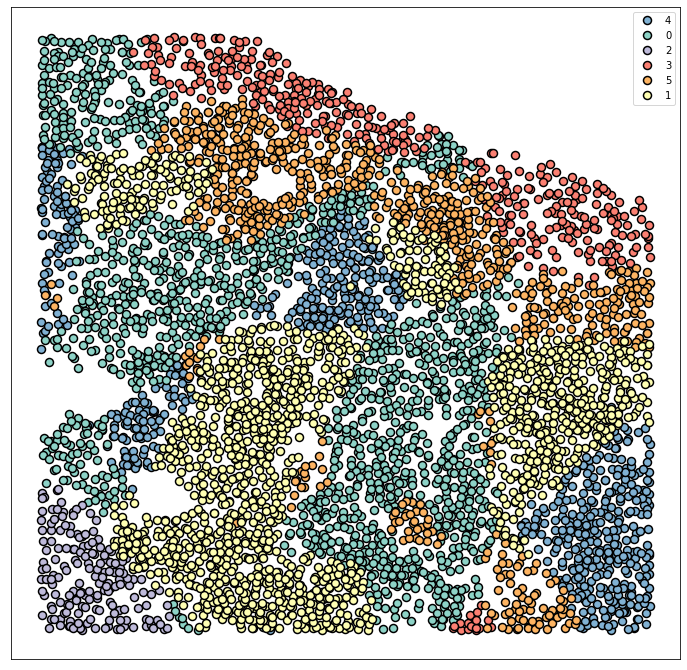

In [66]:
graphplot.scatter_plot_2D(latent_G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (12,12))

In [61]:
def get_latent_probability_field_properties(G, number_of_cell_types):

    resultframe = pandas.DataFrame()
    i = 0
    
    latent_probability_field = nx.get_node_attributes(G, 'latent_probability_field')
    class_dict = nx.get_node_attributes(G, 'class')

    for node in sorted(G.nodes):
        
        resultframe.loc[i, 'label'] = node
        resultframe.loc[i, 'class'] = class_dict[node]
                
        for k in range(number_of_cell_types):
            resultframe.loc[i, k] = latent_probability_field[node][k]
            
        i += 1

    return resultframe.fillna(0)

def get_latent_probability_region_properties(latent_probability_field_properties):

    mean_props = pandas.DataFrame()
    i = 0

    for c in latent_probability_field_properties['class'].unique():

        mean_props.loc[i, 'class'] = c
        mean_props.loc[i, 'size'] = len(latent_probability_field_properties[latent_probability_field_properties['class'] == c])

        for column in latent_probability_field_properties.columns:

            mean_props.loc[i, column] = latent_probability_field_properties[latent_probability_field_properties['class'] == c][column].mean()

        i += 1
        
    return mean_props

In [62]:
latent_probability_field_properties = get_latent_probability_field_properties(biograph.graph, 
                                        biograph.number_of_cell_types)

In [63]:
get_latent_probability_region_properties(latent_probability_field_properties)

,class,size,label,0,1,2,3,4
0,3.0,69.0,2161.724638,0.004681,0.803328,0.000696,0.001425,0.189870
1,10.0,153.0,1983.058824,0.010158,0.618590,0.001772,0.005792,0.363688
2,0.0,161.0,2132.335404,0.001393,0.612610,0.003757,0.025506,0.356734
3,9.0,669.0,2492.820628,0.004991,0.458212,0.005439,0.031765,0.499593
4,4.0,708.0,2546.035311,0.013734,0.456478,0.007468,0.018176,0.504144
5,1.0,748.0,2549.094920,0.005178,0.430612,0.003890,0.010463,0.549856
6,7.0,862.0,2444.002320,0.003516,0.528775,0.010519,0.020133,0.437057
7,6.0,244.0,2298.573770,0.004606,0.590435,0.065768,0.098937,0.240253
8,5.0,624.0,2736.567308,0.011277,0.361009,0.003606,0.018590,0.605518
9,2.0,532.0,2592.642857,0.007969,0.527177,0.024253,0.047853,0.392749


In [102]:
color_list = [plt.cm.Set3(i) for i in range(n_clusters)]

cell_class = nx.get_node_attributes(latent_G, 'class')

for node in G.nodes:
        
    nx.set_node_attributes(latent_G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(latent_G, {node:cell_class[node]}, 'legend')